In [97]:
import numpy as np
import pandas as pd
from collections import Counter
import contractions

import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer

import pandas as pd

import random

import re

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Used for removing accented characters
import unicodedata

# pip install wordcloud
from wordcloud import WordCloud

import csv
from tqdm import tqdm

In [135]:
df = pd.DataFrame()
df = pd.read_csv('new_books_summary.csv')

In [136]:
df

,Unnamed: 0,book_name,cleaned_text,cleaned_text_length,cleaned_genre
0,8,Blade Runner 3: Replicant Night,"['living', 'mar', 'deckard', 'acting', 'consul...",27,"['Science Fiction', 'Speculative fiction']"
1,9,Blade Runner 2: The Edge of Human,"['beginning', 'several', 'month', 'event', 'bl...",163,"['Science Fiction', 'Speculative fiction']"
2,20,Crash,"['story', 'told', 'eye', 'narrator', 'james', ...",55,"['Novel', 'Speculative fiction', 'Fiction']"
3,25,The Cider House Rules,"['homer', 'well', 'grows', 'orphanage', 'spend...",293,['Fiction']
4,31,Death of a Hero,"['death', 'hero', 'story', 'young', 'english',...",194,['Fiction']
...,...,...,...,...,...
7672,16544,Heaven,"['heaven', 'leigh', 'casteel', 'fourteen', 'ye...",655,['Fiction']
7673,16549,The Third Lynx,"['story', 'start', 'former', 'government', 'ag...",85,['Science Fiction']
7674,16551,Remote Control,"['series', 'follows', 'character', 'nick', 'st...",34,['Fiction']
7675,16555,Transfer of Power,"['reader', 'first', 'meet', 'rapp', 'covert', ...",114,['Fiction']


df

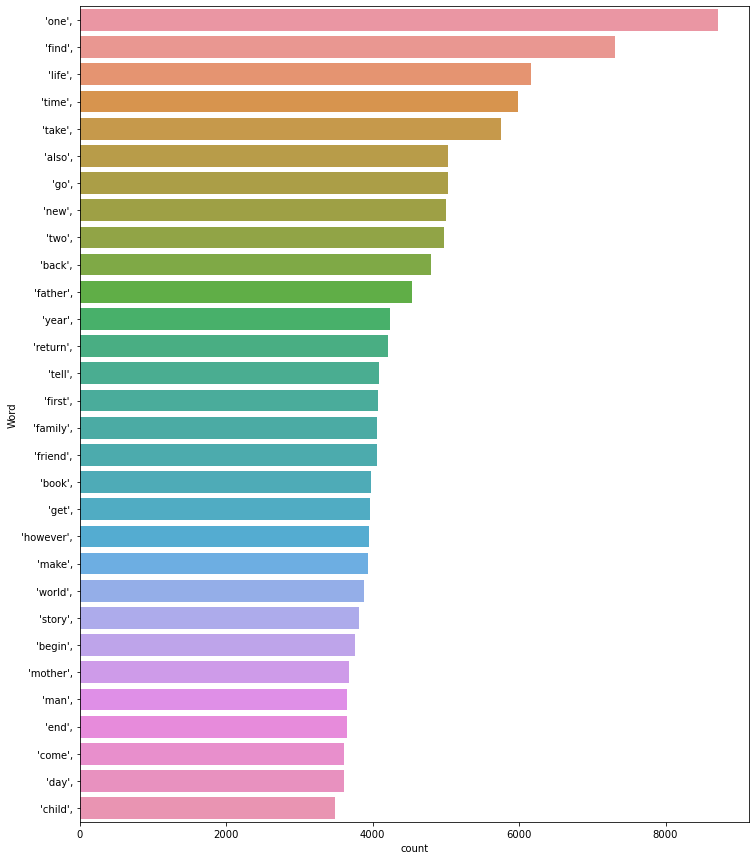

In [137]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
  
freq_words(df['cleaned_text'], 30)

In [143]:
def loop_list(original_list):
    new_list = []
#     print(original_list)
    for item in original_list:
        new_list.append(item.strip())
    return new_list
list_tags = []

df['genre'] = df['cleaned_genre'].apply(lambda x:x.replace("[",'').replace(']','').replace("\"",'').replace('\'','').split(','))
df['genre'] = df['genre'].apply(lambda x:loop_list(x))
df['summary'] = df['cleaned_text'].apply(lambda x:x.replace("[",'').replace(']','').replace("\"",'').replace('\'','').split(','))

In [139]:
df['summary'] = df['summary'].apply(lambda x:"".join(x))

In [140]:
#One hot encoding. I just found an easy way to do that. Do not need that another process
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genre'])

# transform target variable
y = multilabel_binarizer.transform(df['genre'])

In [146]:
print(y[0])
print(multilabel_binarizer.inverse_transform(y)[6])
print(list_tags)

[0 0 0 0 1 1]
('Fantasy', 'Fiction')
[]


In [122]:
xtrain, xval, ytrain, yval = train_test_split(df['summary'], y, test_size=0.2, random_state=9)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

bow_cln_tr = CountVectorizer().fit(df['summary'])
bow_cln_docs = bow_cln_tr.transform(df['summary'])

tfidf_cln_tr = TfidfTransformer().fit(bow_cln_docs)
tfidf_adv_cln_docs = tfidf_cln_tr.transform(bow_cln_docs)

In [123]:
f1_score_dict = {}
accuracy_score_dict = {}

In [124]:
#
# OneVsRestClassifier
#

# OVR + Cleaned Samples
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", OneVsRestClassifier(LogisticRegression()))])
pipeline.fit(xtrain, ytrain)
predictions_cln = pipeline.predict(xval)
f1_score_dict["OneVsRest"] = f1_score(yval, predictions_cln, average="micro")
accuracy_score_dict["OneVsRest"] = accuracy_score(yval,predictions_cln)

In [126]:
#
# Binary Relevance
#

# BR + Cleaned Samples
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", BinaryRelevance(GaussianNB()))])
pipeline.fit(xtrain, ytrain)
predictions_cln = pipeline.predict(xval)
f1_score_dict["BinaryRelevance"] = f1_score(yval, predictions_cln, average="micro")
accuracy_score_dict["BinaryRelevance"] = accuracy_score(yval,predictions_cln)

In [128]:
#
# Classifier Chains
#

# CC + Cleaned Samples
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", ClassifierChain(LogisticRegression()))])
pipeline.fit(xtrain, ytrain)
predictions_cln = pipeline.predict(xval)
f1_score_dict["ClassifierChains"] = f1_score(yval, predictions_cln, average="micro")
accuracy_score_dict["ClassifierChains"] = accuracy_score(yval,predictions_cln)

In [130]:
#
# Label Powerset
#

# LP + Cleaned Samples
from skmultilearn.problem_transform import LabelPowerset
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", LabelPowerset(LogisticRegression()))])
pipeline.fit(xtrain, ytrain)
predictions_cln = pipeline.predict(xval)
f1_score_dict["LabelPowerset"] = f1_score(yval, predictions_cln, average="micro")
accuracy_score_dict["LabelPowerset"] = accuracy_score(yval,predictions_cln)

C:\Users\yinruojiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [131]:
print(f1_score_dict)
print(accuracy_score_dict)

{'OneVsRest': 0.4704532415375789, 'BinaryRelevance': 0.4932754880694143, 'ClassifierChains': 0.5516067248350712, 'LabelPowerset': 0.5747976878612717}
{'OneVsRest': 0.185546875, 'BinaryRelevance': 0.21809895833333334, 'ClassifierChains': 0.2708333333333333, 'LabelPowerset': 0.3391927083333333}


In [132]:
pd.DataFrame(f1_score_dict.items(), columns=["Classifier + Sample Type", "F1_Score"])

,Classifier + Sample Type,F1_Score
0,OneVsRest,0.470453
1,BinaryRelevance,0.493275
2,ClassifierChains,0.551607
3,LabelPowerset,0.574798


In [133]:
pd.DataFrame(accuracy_score_dict.items(), columns=["Classifier + Sample Type", "Accuracy_Score"])

,Classifier + Sample Type,Accuracy_Score
0,OneVsRest,0.185547
1,BinaryRelevance,0.218099
2,ClassifierChains,0.270833
3,LabelPowerset,0.339193
